# Introduction

Recall that this formulation of the k-armed bandit problem selects greedily with probability $1-\epsilon$ and selects for exploration with probability $\epsilon$ (split among the possible states).

In this notebook, we will be looking to reproduce the top part Figure 2.2 of S&B, which plots the average reward for cases with $\epsilon=0.1, \epsilon=0.01, {\rm and } \epsilon=0 ({\rm greedy}).$ We will also add two more plots, with linear and exponential decays in $\epsilon$.

# Generating the Reward Distribution

We would like to generate k Gaussian distributions with variance 1 and means drawn for a Gaussian distribution with variance 1 and mean 0. 

In [1]:
from numpy.random import normal

class random_generator:
    def __init__(self, mean, var):
        self.mean, self.var = mean, var
    
    def generate_next(self):
        return normal(self.mean, self.var)

In [2]:
def get_rewards(k=10, var=1):
    return [random_generator(normal(0, 1), var) for k in range(k)]

# Defining a run

We would like to define a class to store all the information we need to do a run (a run is T timesteps).

In [46]:
import numpy as np
from random import uniform, choice

class Run:
    def __init__(self, k, T, epsilon, var=1):
        self.k = k
        self.T = T
        self.t = 0
        self.epsilon = epsilon #epsilon is a function of t/T
        self.rewards = get_rewards(self.k, var)
        self.action_histories = [[] for k in range(self.k)]
        self.Q = np.zeros(self.k)
        self.reward_history = []
        self.average_reward_history = []
    
    def select_action(self):
        e = self.epsilon(self.t/self.T)
        r = uniform(0, 1)
        greedy_choice = np.argmax(self.Q)
        if r >= e:
            #choose greedily
            a = greedy_choice
        else:
            #choose randomly between others
            choices = list(range(self.k))
            choices.pop(greedy_choice)
            a = choice(choices)
        return a

    def get_reward(self, a):
        return self.rewards[a].generate_next()
    
    def do_iteration(self):
        action = self.select_action()
        reward = self.get_reward(action)
        self.reward_history.append(reward)
        self.average_reward_history.append(np.mean(self.reward_history))
        self.action_histories[action].append(reward)
        self.update_Q(action, reward)
        self.t += 1
    
    def do_run(self):
        while self.t < self.T:
            self.do_iteration()
    
    def update_Q(self, a, r):
        self.Q[a] = np.mean(self.action_histories[a])

In [29]:
def do_N_runs(N, k, T, epsilon, var=1):
    results = []
    for n in range(N):
        run = Run(k, T, epsilon, var)
        run.do_run()
        result = run.average_reward_history
        results.append(result)
    
    averaged_result = [np.mean([r[i] for r in results]) for i in range(T)]
    return averaged_result

# Re-creating Fig 2.2

We are able to successfully recreate this plot (though ours is less jagged because we are doing more averaging. Instead of 2000 independent runs, we use 250 (to do the computation in a reasonable amount of time).

In [47]:
results_0 = do_N_runs(250, 10, 1000, lambda _: 0)
results_01 = do_N_runs(250, 10, 1000, lambda _: 0.1)
results_001 = do_N_runs(250, 10, 1000, lambda _:0.01)

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,0,'Steps')

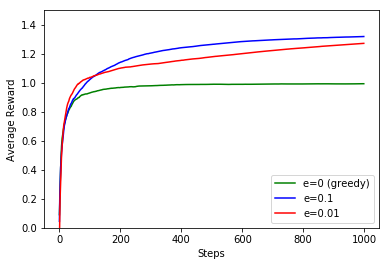

In [49]:
plt.plot(results_0, c='green', label='e=0 (greedy)')
plt.plot(results_01, c='blue', label='e=0.1')
plt.plot(results_001, c='red', label='e=0.01')
plt.legend()
plt.ylim((0,1.5))
plt.ylabel('Average Reward')
plt.xlabel('Steps')

# Adding time-dependent epsilons

We now try adding two different time dependent epsilons. The first decreases linearly with time from 0.1 to 0. The second decreases exponentially with time from 0.1 to 0. We see that the linear decay produces the best result, while the exponential decay is probably too rapid, and produces results comparable to $\epsilon=0.01$.

In [21]:
results_lin_t = do_N_runs(250, 10, 1000, lambda x: 0.1*(1-x))
results_exp_t = do_N_runs(250, 10, 1000, lambda x: 0.01 * (1-np.exp(x-1)) / (1-np.exp(-1)))

Text(0.5,0,'Steps')

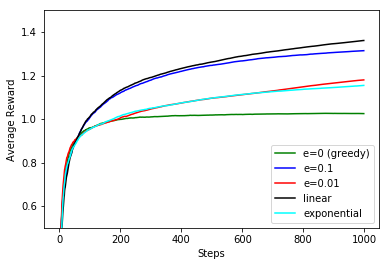

In [22]:
plt.plot(results_0, c='green', label='e=0 (greedy)')
plt.plot(results_01, c='blue', label='e=0.1')
plt.plot(results_001, c='red', label='e=0.01')
plt.plot(results_lin_t, c='black', label='linear')
plt.plot(results_exp_t, c='cyan', label='exponential')
plt.legend()
plt.ylim((0.5,1.5))
plt.ylabel('Average Reward')
plt.xlabel('Steps')

# Changing k

If we increase k, as we do below from 10 to 50, then we expect that exploring the parameter space will be more rewarding, so we expect a greater difference between high epsilon and low epsilon. The reward distribution will also likely have a higher top-end, so we expect the overall scale to be higher than in the previous case. This is indeed what we see.

Similarly, if we decrease K, as we do below from 10 to 4, then we expect exploring the parameter space will be less rewarding, so we expect a smaller difference between high epsilon and low epsilon. This indeed what we see - The linear/exponential/$\epsilon=0.01$ distributions are now almost all equal, while $\epsilon=0.1$ fares much worse. But the greedy algorithm still fares the worst.

In [23]:
results_0 = do_N_runs(250, 50, 1000, lambda _: 0)
results_01 = do_N_runs(250, 50, 1000, lambda _: 0.1)
results_001 = do_N_runs(250, 50, 1000, lambda _:0.01)
results_lin_t = do_N_runs(250, 50, 1000, lambda x: 0.1*(1-x))
results_exp_t = do_N_runs(250, 50, 1000, lambda x: 0.01 * (1-np.exp(x-1)) / (1-np.exp(-1)))

Text(0.5,1,'K=50')

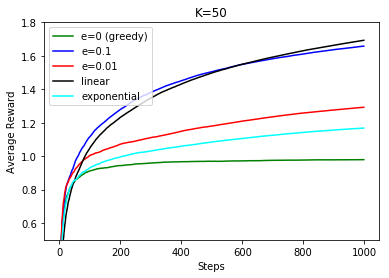

In [24]:
plt.plot(results_0, c='green', label='e=0 (greedy)')
plt.plot(results_01, c='blue', label='e=0.1')
plt.plot(results_001, c='red', label='e=0.01')
plt.plot(results_lin_t, c='black', label='linear')
plt.plot(results_exp_t, c='cyan', label='exponential')
plt.legend()
plt.ylim((0.5, 1.8))
plt.ylabel('Average Reward')
plt.xlabel('Steps')
plt.title('K=50')

In [25]:
results_0 = do_N_runs(250, 4, 1000, lambda _: 0)
results_01 = do_N_runs(250, 4, 1000, lambda _: 0.1)
results_001 = do_N_runs(250, 4, 1000, lambda _:0.01)
results_lin_t = do_N_runs(250, 4, 1000, lambda x: 0.1*(1-x))
results_exp_t = do_N_runs(250, 4, 1000, lambda x: 0.01 * (1-np.exp(x-1)) / (1-np.exp(-1)))

Text(0.5,1,'K=4')

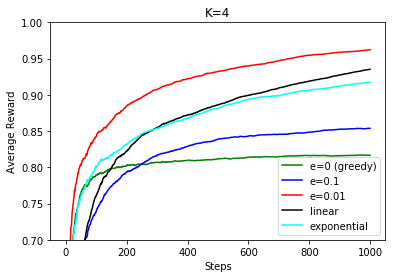

In [26]:
plt.plot(results_0, c='green', label='e=0 (greedy)')
plt.plot(results_01, c='blue', label='e=0.1')
plt.plot(results_001, c='red', label='e=0.01')
plt.plot(results_lin_t, c='black', label='linear')
plt.plot(results_exp_t, c='cyan', label='exponential')
plt.legend()
plt.ylim((0.7, 1.0))
plt.ylabel('Average Reward')
plt.xlabel('Steps')
plt.title('K=4')